In [1]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP, MLP
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

import numpy as np
import copy 
import time
from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import trange
from scipy.sparse.csgraph import connected_components
import pickle
import os
import math

In [3]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import argparse
"""
Dataset arguments
"""
parser = argparse.ArgumentParser(
    description='Training GCN on Large-scale Graph Datasets')
parser.add_argument('--dataset', type=str, default='cora',
                    help='Dataset name: pubmed/flickr/reddit/ppi-large')
parser.add_argument('--method', type=str, default='GCN/ResGCN/GCNII/APPNP/DGCN', # SGC/GCN/GCNBias/ResGCN/GCNII/APPNP
                    help='Algorithms: seperate using slash')
parser.add_argument('--nhid', type=int, default=64,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default=300,
                    help='Number of Epoch')
parser.add_argument('--batch_size', type=int, default=20480000000,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=16,
                    help='Number of GCN layers')
parser.add_argument('--dropout', type=float, default=0,
                    help='Dropout rate')
parser.add_argument('--cuda', type=int, default=0,
                    help='Avaiable GPU ID')
args = parser.parse_args()
print(args)

method = args.method.split('/')

"""
Prepare devices
"""
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")
    
if args.dataset not in ['cora', 'citeseer', 'pubmed']:
    temp_data = load_data(args.dataset) 
else:
    temp_data = load_data_gcn(args.dataset)

adj_full, adj_train, feat_data, labels, role = process_graph_data(*temp_data)

train_nodes = np.array(role['tr'])
valid_nodes = np.array(role['va'])
test_nodes = np.array(role['te'])

data_loader = DataLoader(adj_full, train_nodes, valid_nodes, test_nodes, device)

Namespace(batch_size=20480000000, cuda=0, dataset='cora', dropout=0, epoch_num=300, method='GCN/ResGCN/GCNII/APPNP/DGCN', n_layers=16, nhid=64)


In [4]:
"""
Setup datasets and models for training (multi-class use sigmoid+binary_cross_entropy, use softmax+nll_loss otherwise)
"""

if args.dataset in ['flickr', 'reddit', 'cora', 'citeseer', 'pubmed']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.LongTensor(labels.argmax(1))
    num_classes = labels_th.max().item()+1
    criterion = nn.CrossEntropyLoss()
    multi_class=False
elif args.dataset in ['ppi', 'ppi-large', 'amazon', 'yelp']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.FloatTensor(labels)
    num_classes = labels_th.shape[1]
    criterion = nn.BCEWithLogitsLoss()
    multi_class=True

feat_data_th = feat_data_th.to(device)
labels_th = labels_th.to(device)

def sgd_step(net, optimizer, feat_data, labels, train_data, device):
    """
    Function to updated weights with a SGD backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    net.train()
    epoch_loss = []
    epoch_acc = []
    
    # Run over the train_loader
    mini_batches, adj = train_data
    for mini_batch in mini_batches:

        # compute current stochastic gradient
        optimizer.zero_grad()
        output = net(feat_data, adj)
        
        loss = net.criterion(output[mini_batch], labels[mini_batch])
        loss.backward()
        
        optimizer.step()
        epoch_loss.append(loss.item())
        
        if multi_class:
            output[output > 0.5] = 1
            output[output <= 0.5] = 0
        else:
            output = output.argmax(dim=1)

        acc = f1_score(output[mini_batch].detach().cpu(), 
                       labels[mini_batch].detach().cpu(), average="micro")
        epoch_acc.append(acc)

    return epoch_loss, epoch_acc

@torch.no_grad()
def inference(eval_model, feat_data, labels, test_data, device):
    eval_model = eval_model.to(device)
    mini_batch, adj = test_data    
    output = eval_model(feat_data, adj)
    loss = eval_model.criterion(output[mini_batch], labels[mini_batch]).item()
    
    if multi_class:
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
    else:
        output = output.argmax(dim=1)
        
    acc = f1_score(output[mini_batch].detach().cpu(), 
                   labels[mini_batch].detach().cpu(), average="micro")
    return loss, acc

In [5]:
"""
Train without sampling
"""

def train_model(model, data_loader, note):
    train_model = copy.deepcopy(model).to(device)
    
    results = ResultRecorder(note=note)
    
    optimizer = optim.Adam(train_model.parameters())

    tbar = trange(args.epoch_num, desc='Training Epochs')
    for epoch in tbar:
        # fetch train data 
        
        sample_time_st = time.perf_counter()
        train_data = data_loader.get_mini_batches(batch_size=args.batch_size)
        sample_time = time.perf_counter() - sample_time_st
        
        compute_time_st = time.perf_counter()
        train_loss, train_acc = sgd_step(train_model, optimizer, feat_data_th, labels_th, train_data, device)
        compute_time = time.perf_counter() - compute_time_st
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)

        valid_data = data_loader.get_valid_batch()
        epoch_valid_loss, epoch_valid_acc = inference(train_model, feat_data_th, labels_th, valid_data, device)
        tbar.set_postfix(loss=epoch_train_loss,
                         val_loss=epoch_valid_loss,
                         val_score=epoch_valid_acc)

        results.update(epoch_train_loss, 
                       epoch_train_acc,
                       epoch_valid_loss, 
                       epoch_valid_acc, 
                       train_model, sample_time=sample_time, compute_time=compute_time)
            
    print('Average sampling time %.5fs, average computing time %.5fs'%
          (np.mean(results.sample_time), np.mean(results.compute_time)))
    
    return results

In [6]:
import math

In [7]:

    
class GCNII(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion, alpha, beta):
        from layers import GCNIILayer
        super(GCNII, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GCNIILayer(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion
        self.alpha = alpha
        self.beta = beta

    def get_alpha_beta(self, ell):
        # alpha = 0.9
        # beta = math.log(0.5/(ell+1)+1)
        return self.alpha, self.beta
    
    def forward(self, x, adj):
        x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            alpha, beta = self.get_alpha_beta(ell)
            x = self.gcs[ell](x, adj, x_0, alpha, beta)
            x = self.relu(x)
        x = self.linear_out(x)
        return x

In [8]:
algorithm_result = dict()
print(method)

alpha_candidates = [0.9, 0.7, 0.5, 0.3, 0.1]
beta_candidates = [0.9, 0.7, 0.5, 0.3, 0.1]

['GCN', 'ResGCN', 'GCNII', 'APPNP', 'DGCN']


In [9]:
algorithm_result

{}

In [10]:

for repeat in range(10):
    
    # for alpha in alpha_candidates:
    #     beta = 0.2
    for beta in beta_candidates:
        alpha=0.9
        
        result_name = 'GCNII_%.1f_%.1f'%(alpha, beta)
        if result_name not in algorithm_result.keys():
            algorithm_result[result_name] = list()
        
        model = GCNII(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    criterion=criterion, 
                    alpha=alpha, beta=beta)

        results = train_model(model, data_loader, note="GCNII (L=%d, repeat=%d)"%(args.n_layers, repeat))
        results = np.array([
            results.train_loss_record,
            results.train_acc_record,
            results.loss_record,
            results.acc_record
        ])
        algorithm_result['GCNII_%.1f_%.1f'%(alpha, beta)].append(results)   

Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.74it/s, loss=1.96, val_loss=1.95, val_score=0.078]

Average sampling time 0.00006s, average computing time 0.01889s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.23it/s, loss=1.91, val_loss=1.91, val_score=0.294]

Average sampling time 0.00005s, average computing time 0.01886s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.35it/s, loss=1.94, val_loss=1.94, val_score=0.106]

Average sampling time 0.00006s, average computing time 0.01887s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 34.51it/s, loss=1.89, val_loss=1.88, val_score=0.318]

Average sampling time 0.00006s, average computing time 0.01885s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.68it/s, loss=1.94, val_loss=1.94, val_score=0.158]

Average sampling time 0.00005s, average computing time 0.01883s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.85it/s, loss=1.93, val_loss=1.93, val_score=0.294]

Average sampling time 0.00006s, average computing time 0.01889s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.90it/s, loss=1.95, val_loss=1.95, val_score=0.158]

Average sampling time 0.00006s, average computing time 0.01889s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.06it/s, loss=1.96, val_loss=1.95, val_score=0.232]

Average sampling time 0.00006s, average computing time 0.01909s


Training Epochs:   1%|▏         | 4/300 [00:00<00:09, 32.62it/s, loss=1.94, val_loss=1.93, val_score=0.254]

Average sampling time 0.00006s, average computing time 0.01889s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 32.97it/s, loss=1.94, val_loss=1.94, val_score=0.296]

Average sampling time 0.00006s, average computing time 0.01891s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 34.56it/s, loss=1.94, val_loss=1.94, val_score=0.182]

Average sampling time 0.00006s, average computing time 0.01895s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.64it/s, loss=1.96, val_loss=1.96, val_score=0.12] 

Average sampling time 0.00006s, average computing time 0.01889s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.20it/s, loss=1.95, val_loss=1.94, val_score=0.074]

Average sampling time 0.00006s, average computing time 0.01884s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.28it/s, loss=1.93, val_loss=1.92, val_score=0.244]

Average sampling time 0.00005s, average computing time 0.01889s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.85it/s, loss=1.93, val_loss=1.92, val_score=0.158]

Average sampling time 0.00006s, average computing time 0.01887s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 36.07it/s, loss=1.95, val_loss=1.95, val_score=0.072]

Average sampling time 0.00005s, average computing time 0.01888s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.79it/s, loss=1.94, val_loss=1.93, val_score=0.158]

Average sampling time 0.00006s, average computing time 0.01887s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.74it/s, loss=1.95, val_loss=1.95, val_score=0.12]

Average sampling time 0.00006s, average computing time 0.01888s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.04it/s, loss=1.92, val_loss=1.92, val_score=0.396]

Average sampling time 0.00006s, average computing time 0.01881s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.73it/s, loss=1.92, val_loss=1.92, val_score=0.294]

Average sampling time 0.00006s, average computing time 0.01894s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.71it/s, loss=1.91, val_loss=1.91, val_score=0.294]

Average sampling time 0.00006s, average computing time 0.01886s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.99it/s, loss=1.94, val_loss=1.94, val_score=0.158]

Average sampling time 0.00005s, average computing time 0.01887s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.37it/s, loss=1.94, val_loss=1.94, val_score=0.314]

Average sampling time 0.00005s, average computing time 0.01888s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.53it/s, loss=1.9, val_loss=1.9, val_score=0.294]  

Average sampling time 0.00006s, average computing time 0.01888s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.78it/s, loss=1.94, val_loss=1.93, val_score=0.2]  

Average sampling time 0.00005s, average computing time 0.01885s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.70it/s, loss=1.94, val_loss=1.94, val_score=0.158]

Average sampling time 0.00006s, average computing time 0.01892s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.66it/s, loss=1.95, val_loss=1.95, val_score=0.16] 

Average sampling time 0.00006s, average computing time 0.01887s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 34.73it/s, loss=1.94, val_loss=1.94, val_score=0.136]

Average sampling time 0.00006s, average computing time 0.01888s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 34.29it/s, loss=1.89, val_loss=1.88, val_score=0.304]

Average sampling time 0.00005s, average computing time 0.01889s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.50it/s, loss=1.94, val_loss=1.94, val_score=0.174]

Average sampling time 0.00006s, average computing time 0.01888s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.98it/s, loss=1.95, val_loss=1.95, val_score=0.072]

Average sampling time 0.00006s, average computing time 0.01886s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.32it/s, loss=1.93, val_loss=1.93, val_score=0.3]  

Average sampling time 0.00006s, average computing time 0.01885s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 34.80it/s, loss=1.93, val_loss=1.93, val_score=0.17] 

Average sampling time 0.00005s, average computing time 0.01896s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.92it/s, loss=1.91, val_loss=1.91, val_score=0.284]

Average sampling time 0.00005s, average computing time 0.01887s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.12it/s, loss=1.94, val_loss=1.94, val_score=0.104]

Average sampling time 0.00006s, average computing time 0.01887s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 32.91it/s, loss=1.94, val_loss=1.94, val_score=0.244]

Average sampling time 0.00006s, average computing time 0.01891s


Training Epochs:   1%|▏         | 4/300 [00:00<00:09, 32.86it/s, loss=1.94, val_loss=1.94, val_score=0.248]

Average sampling time 0.00005s, average computing time 0.01890s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.13it/s, loss=1.92, val_loss=1.92, val_score=0.344]

Average sampling time 0.00006s, average computing time 0.01890s


Training Epochs:   1%|▏         | 4/300 [00:00<00:09, 32.79it/s, loss=1.92, val_loss=1.91, val_score=0.382]

Average sampling time 0.00006s, average computing time 0.01887s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.10it/s, loss=1.94, val_loss=1.93, val_score=0.174]

Average sampling time 0.00005s, average computing time 0.01892s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.97it/s, loss=1.93, val_loss=1.93, val_score=0.294]

Average sampling time 0.00005s, average computing time 0.01890s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.06it/s, loss=1.94, val_loss=1.94, val_score=0.12]

Average sampling time 0.00006s, average computing time 0.01889s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.15it/s, loss=1.93, val_loss=1.93, val_score=0.342]

Average sampling time 0.00005s, average computing time 0.01891s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 34.88it/s, loss=1.93, val_loss=1.92, val_score=0.142]

Average sampling time 0.00006s, average computing time 0.01891s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.69it/s, loss=1.94, val_loss=1.94, val_score=0.2]  

Average sampling time 0.00006s, average computing time 0.01892s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.97it/s, loss=1.93, val_loss=1.92, val_score=0.294]

Average sampling time 0.00006s, average computing time 0.01888s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.76it/s, loss=1.96, val_loss=1.96, val_score=0.08] 

Average sampling time 0.00006s, average computing time 0.01888s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 35.19it/s, loss=1.92, val_loss=1.92, val_score=0.294]

Average sampling time 0.00006s, average computing time 0.01894s


Training Epochs:   1%|▏         | 4/300 [00:00<00:08, 33.22it/s, loss=1.9, val_loss=1.9, val_score=0.45]   

Average sampling time 0.00006s, average computing time 0.01891s


Training Epochs: 100%|██████████| 300/300 [00:08<00:00, 34.71it/s, loss=0.0424, val_loss=0.578, val_score=0.87] 

Average sampling time 0.00006s, average computing time 0.01893s


In [11]:
def get_mean_std_epoch_result(all_epoch_results):

    all_train_loss = []
    all_valid_loss = []
    all_train_acc = []
    all_valid_acc = []
    all_gen_error = []

    for epoch_results in all_epoch_results:
        all_train_loss.append(epoch_results[0,:])
        all_valid_loss.append(epoch_results[2,:])
        all_train_acc.append(epoch_results[1,:])
        all_valid_acc.append(epoch_results[3,:])
        all_gen_error.append(epoch_results[2,:] - epoch_results[0,:])

    all_epoch_results_mean = np.array([np.mean(all_train_loss, axis=0),
                                       np.mean(all_valid_loss, axis=0),
                                       np.mean(all_train_acc, axis=0),
                                       np.mean(all_valid_acc, axis=0),
                                       np.mean(all_gen_error, axis=0)])

    all_epoch_results_std = np.array([np.std(all_train_loss, axis=0),
                                      np.std(all_valid_loss, axis=0),
                                      np.std(all_train_acc, axis=0),
                                      np.std(all_valid_acc, axis=0),
                                      np.std(all_gen_error, axis=0)])
    
    return all_epoch_results_mean, all_epoch_results_std

(5, 300) (5, 300)
GCNII_0.9_0.9 0.7203494056127966
(5, 300) (5, 300)
GCNII_0.9_0.7 0.3050482541322708
(5, 300) (5, 300)
GCNII_0.9_0.5 0.34338483586907387
(5, 300) (5, 300)
GCNII_0.9_0.3 0.4151955969631672
(5, 300) (5, 300)
GCNII_0.9_0.1 0.22258733958005905


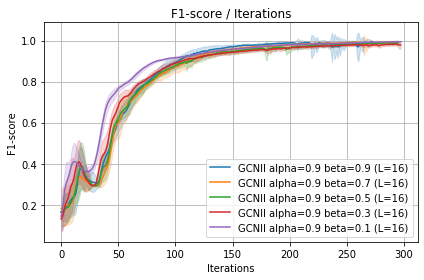

In [12]:
fig, axs = plt.subplots()
n_layers = args.n_layers

# beta=0.2
# for alpha in alpha_candidates:
alpha=0.9
for beta in beta_candidates:
    algorithm = 'GCNII_%.1f_%.1f'%(alpha, beta)
    color = next(axs._get_lines.prop_cycler)['color']
    
    all_epoch_results = algorithm_result[algorithm]
    all_epoch_results_mean, all_epoch_results_std = get_mean_std_epoch_result(all_epoch_results)
    print(all_epoch_results_mean.shape, all_epoch_results_std.shape)
    
    best_iter = np.argmax(all_epoch_results_mean[3]) # valid acc
    stop_iter = np.argmax(all_epoch_results_mean[2]) # train acc

    y_vals = all_epoch_results_mean[2][:stop_iter]
    y_stds = all_epoch_results_std[2][:stop_iter]
    x_vals = np.arange(len(y_vals))
    
    algorithm_n = 'GCNII alpha=%.1f beta=%.1f'%(alpha, beta)
    axs.plot(x_vals, y_vals, label='%s (L=%d)'%(algorithm_n, n_layers), color=color, linestyle='-')
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2, color=color)

#     y_vals = all_epoch_results_mean[3][:stop_iter]
#     y_stds = all_epoch_results_std[3][:stop_iter]
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s (L=%d): Valid'%(algorithm, n_layers), color=color, linestyle='--')
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2, color=color)
    
    print(algorithm, all_epoch_results_mean[4][best_iter])

plt.title('F1-score / Iterations')
axs.set_ylabel('F1-score')
axs.set_xlabel('Iterations')
axs.grid(True)
fig.tight_layout()
plt.legend()
plt.savefig('f1_score_synthetic.pdf')
# plt.close()

In [13]:
all_epoch_results_mean.shape

(5, 300)

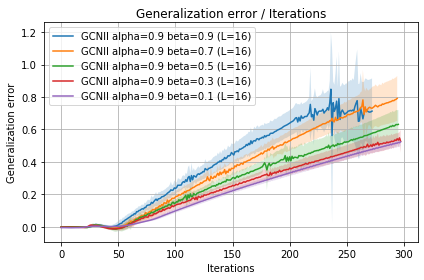

In [14]:
fig, axs = plt.subplots()

# beta=0.2
# for alpha in alpha_candidates:
alpha=0.9
for beta in beta_candidates:
    algorithm = 'GCNII_%.1f_%.1f'%(alpha, beta)
    
    all_epoch_results = algorithm_result[algorithm]
    all_epoch_results_mean, all_epoch_results_std = get_mean_std_epoch_result(all_epoch_results)

    best_iter = np.argmax(all_epoch_results_mean[3])
    stop_iter = np.argmax(all_epoch_results_mean[2])
    
    y_vals = all_epoch_results_mean[4][:stop_iter]
    y_stds = all_epoch_results_std[4][:stop_iter]
    x_vals = np.arange(len(y_vals))
    
    algorithm_n = 'GCNII alpha=%.1f beta=%.1f'%(alpha, beta)
    axs.plot(x_vals, y_vals, label='%s (L=%d)'%(algorithm_n, n_layers))
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2)


plt.title('Generalization error / Iterations')
axs.set_ylabel('Generalization error')
axs.set_xlabel('Iterations')
axs.grid(True)
fig.tight_layout()
plt.legend()
plt.savefig('generalization_error_synthetic.pdf')
# plt.close()